# Спектральная кластеризация для сегментации изображений
В этом примере создаётся изображение с соединёнными кругами, а для разделения кругов используется спектральная кластеризация.

В таких условиях подход спектральной кластеризации решает задачу, известную как «нормализованное разрезание графа»: изображение рассматривается как граф, состоящий из связанных вокселей, а алгоритм спектральной кластеризации сводится к выбору разрезов графа, определяющих области, при минимизации отношения градиента вдоль разреза к объёму области.

Поскольку алгоритм пытается сбалансировать объём (то есть сбалансировать размеры областей), если мы возьмём круги разных размеров, сегментация не удастся.

Кроме того, поскольку в интенсивности изображения или его градиенте нет полезной информации, мы решили выполнить спектральную кластеризацию на графике, который лишь слабо связан с градиентом. Это близко к выполнению разбиения графа по Вороному.

Кроме того, мы используем маску объектов, чтобы ограничить график контуром объектов. В этом примере мы хотим отделить объекты друг от друга, а не от фона.

## Сгенерируйте данные

In [2]:
import numpy as np

l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1**2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2**2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3**2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4**2

## Построение четырех кругов

In [3]:
img = circle1 + circle2 + circle3 + circle4

# We use a mask that limits to the foreground: the problem that we are
# interested in here is not separating the objects from the background,
# but separating them one from the other.
mask = img.astype(bool)

img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)

Преобразуйте изображение в график со значением градиента на краях.

In [4]:
from sklearn.feature_extraction import image

graph = image.img_to_graph(img, mask=mask)

Возьмите убывающую функцию градиента, которая приводит к сегментации, близкой к разбиению Вороного

In [5]:
graph.data = np.exp(-graph.data / graph.data.std())

Здесь мы выполняем спектральную кластеризацию с помощью решателя arpack, поскольку в этом примере алгоритм amg нестабилен. Затем мы строим график результатов.

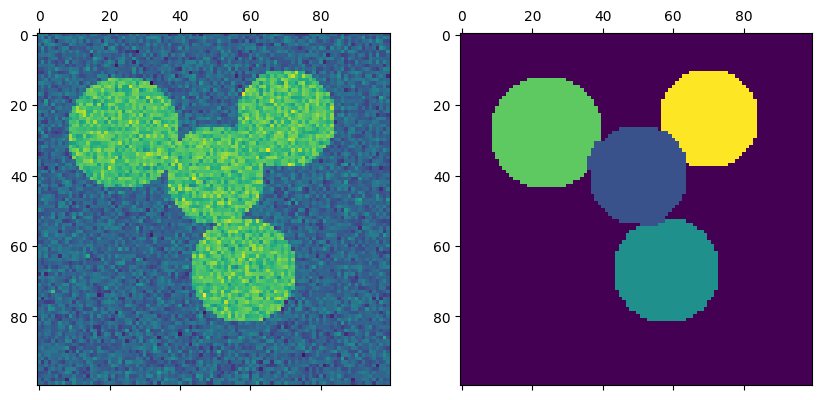

In [6]:
import matplotlib.pyplot as plt

from sklearn.cluster import spectral_clustering

labels = spectral_clustering(graph, n_clusters=4, eigen_solver="arpack")
label_im = np.full(mask.shape, -1.0)
label_im[mask] = labels

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(img)
axs[1].matshow(label_im)

plt.show()

## Построение двух окружностей

Здесь мы повторяем описанный выше процесс, но рассматриваем только первые два сгенерированных нами круга. Обратите внимание, что в этом случае круги лучше разделяются, так как размеры областей легче сбалансировать.

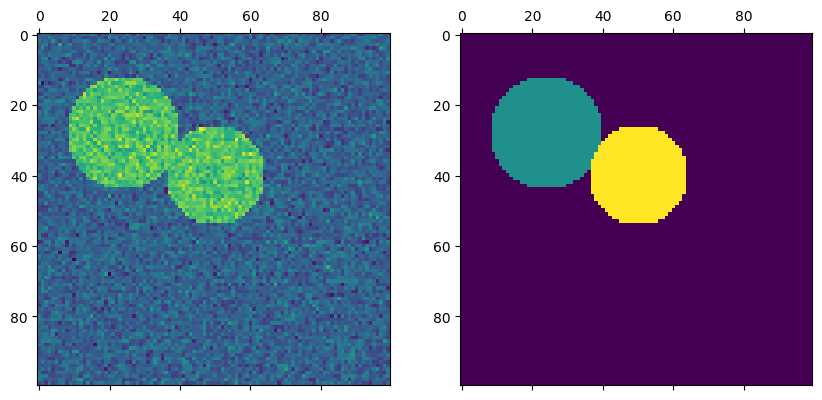

In [7]:
img = circle1 + circle2
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.2 * np.random.randn(*img.shape)

graph = image.img_to_graph(img, mask=mask)
graph.data = np.exp(-graph.data / graph.data.std())

labels = spectral_clustering(graph, n_clusters=2, eigen_solver="arpack")
label_im = np.full(mask.shape, -1.0)
label_im[mask] = labels

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(img)
axs[1].matshow(label_im)

plt.show()